![](http://i67.tinypic.com/2jcbwcw.png)

## Data-X: Titanic Survival Analysis

**Authors:** Several public Kaggle Kernels, edits by Alexander Fred Ojala & Kevin Li

<img src="data/Titanic_Variable.png">

# Note

Install xgboost package in  your pyhton  enviroment:

try:
```
$ conda install py-xgboost
```


In [4]:
'''
# You can also install the package by running the line below
# directly in your notebook
''';

#!conda install py-xgboost --y

## Import packages

In [5]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 9 , 5

### Define fancy plot to look at distributions

In [6]:
# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

## References to material we won't cover in detail:

* **Gradient Boosting:** http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

* **Naive Bayes:** http://scikit-learn.org/stable/modules/naive_bayes.html

* **Perceptron:** http://aass.oru.se/~lilien/ml/seminars/2007_02_01b-Janecek-Perceptron.pdf

## Input Data

In [7]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
combine = [train_df, test_df]

# NOTE! When we change train_df or test_df the objects in combine 
# will also change
# (combine is only a pointer to the objects)


# combine is used to ensure whatever preprocessing is done
# on training data is also done on test data

# Exploratory Data Anlysis (EDA)
We will analyze the data to see how we can work with it and what makes sense.

In [8]:
print(train_df.columns.values) 

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [9]:
# preview the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# General data statistics
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# Data Frame information (null, data type etc)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Comment on the Data
<div class='alert alert-info'>
`PassengerId` is a random number and thus does not contain any valuable information. `Survived, Passenger Class, Age Siblings Spouses, Parents Children` and `Fare` are numerical values -- so we don't need to transform them, but we might want to group them (i.e. create categorical variables). `Sex, Embarked` are categorical features that we need to map to integer values. `Name, Ticket` and `Cabin` might also contain valuable information.
</div>

# Preprocessing Data

In [12]:
# check dimensions of the train and test datasets
print("Shapes Before: (train) (test) = ", \
      train_df.shape, test_df.shape)

Shapes Before: (train) (test) =  (891, 12) (418, 11)


In [13]:
# Drop columns 'Ticket', 'Cabin', need to do it for both test
# and training

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("Shapes After: (train) (test) =", train_df.shape, test_df.shape)

Shapes After: (train) (test) = (891, 10) (418, 9)


In [14]:
# Check if there are null values in the datasets

print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


### Hypothesis
The Title of the person is a feature that can predict survival

In [15]:
# List example titles in Name column
train_df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [16]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'
# if you want to match Titles or names with any other expression
# refer to this tutorial on regex in python:
# https://www.tutorialspoint.com/python/python_reg_expressions.htm

# Create new column called title

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.',\
                                                expand=False)

In [17]:
# Double check that our titles makes sense (by comparing to sex)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [18]:
# same for test set
pd.crosstab(test_df['Title'], test_df['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [19]:
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Rare'

for dataset in combine:
    dataset['Title'] = dataset['Title'].\
                  replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss') #Mademoiselle
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs') #Madame

In [20]:
# Now that we have more logical titles, and a few groups
# we can plot the survival chance for each title

train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


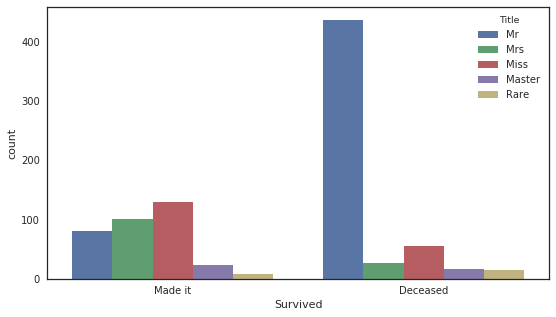

In [21]:
# We can also plot it
sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

In [22]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
Title            0
dtype: int64

In [23]:
# Title dummy mapping
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Title)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


In [24]:
train_df = train_df.drop(['Name', 'Title', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name', 'Title'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 13), (418, 13))

In [25]:
# Map Sex to binary categories
for dataset in combine:
    dataset['Sex'] = dataset['Sex']. \
        map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35.0,0,0,8.0500,S,0,0,1,0,0


### Handle missing values for age
We will now guess values of age based on sex (male / female) 
and socioeconomic class (1st,2nd,3rd) of the passenger.

The row indicates the sex, male = 0, female = 1

More refined estimate than only median / mean etc.

In [26]:
guess_ages = np.zeros((2,3),dtype=int) #initialize
guess_ages

array([[0, 0, 0],
       [0, 0, 0]])

In [27]:
# Fill the NA's for the Age columns
# with "qualified guesses"

for idx,dataset in enumerate(combine):
    if idx==0:
        print('Working on Training Data set\n')
    else:
        print('-'*35)
        print('Working on Test Data set\n')
    
    print('Guess values of age based on sex and pclass of the passenger...')
    for i in range(0, 2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex'] == i) \
                        &(dataset['Pclass'] == j+1)]['Age'].dropna()

            # Extract the median age for this group
            # (less sensitive) to outliers
            age_guess = guess_df.median()
          
            # Convert random age float to int
            guess_ages[i,j] = int(age_guess)
    
            
    print('Guess_Age table:\n',guess_ages)
    print ('\nAssigning age values to NAN age values in the dataset...')
    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) \
                    & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
                    

    dataset['Age'] = dataset['Age'].astype(int)
    print()
print('Done!')
train_df.head()

Working on Training Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[40 30 25]
 [35 28 21]]

Assigning age values to NAN age values in the dataset...

-----------------------------------
Working on Test Data set

Guess values of age based on sex and pclass of the passenger...
Guess_Age table:
 [[42 28 24]
 [41 24 22]]

Assigning age values to NAN age values in the dataset...

Done!


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35,0,0,8.0500,S,0,0,1,0,0


In [28]:
# Split into age bands and look at survival rates
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False)\
                    .mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


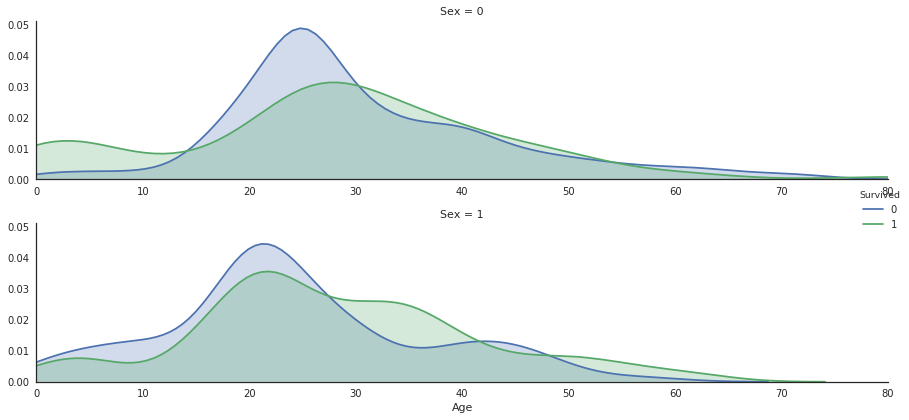

In [29]:
# Plot distributions of Age of passangers who survived 
# or did not survive

plot_distribution( train_df , var = 'Age' , target = 'Survived' ,\
                  row = 'Sex' )

In [30]:
# Change Age column to
# map Age ranges (AgeBands) to integer values of categorical type 
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']=4
train_df.head()

# Note we could just run 
# dataset['Age'] = pd.cut(dataset['Age'], 5,labels=[0,1,2,3,4])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,0,1,1,0,7.2500,S,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,0,0,1,0,0,"(32.0, 48.0]"


In [31]:
# remove AgeBand from before
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,1,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,2,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,1,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,2,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,2,0,0,8.0500,S,0,0,1,0,0


# Create variable for Family Size

How did the number of people the person traveled with impact the chance of survival?

In [32]:
# SibSp = Number of Sibling / Spouses
# Parch = Parents / Children

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    
# Survival chance with FamilySize

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


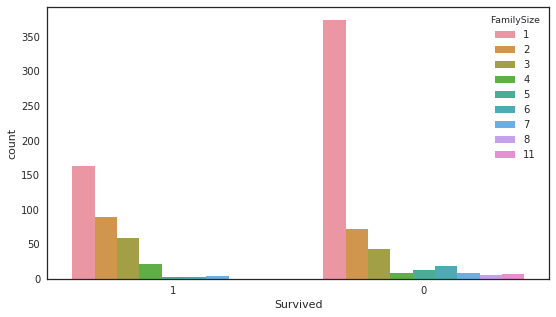

In [33]:
# Plot it, 1 is survived
sns.countplot(x='Survived', hue="FamilySize", data=train_df, order=[1,0]);

In [34]:
# Binary variable if the person was alone or not

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [35]:
# We will only use the binary IsAlone feature for further analysis

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone
0,0,3,0,1,7.2500,S,0,0,1,0,0,0
1,1,1,1,2,71.2833,C,0,0,0,1,0,0
2,1,3,1,1,7.9250,S,0,1,0,0,0,1
3,1,1,1,2,53.1000,S,0,0,0,1,0,0
4,0,3,0,2,8.0500,S,0,0,1,0,0,1


In [36]:
# We can also create new features based on intuitive combinations
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(8)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3


# Port the person embarked from
Let's see how that influences chance of survival

In [37]:
# To replace Nan value in 'Embarked', we will use the mode
# in 'Embaraked'. This will give us the most frequent port 
# the passengers embarked from

freq_port = train_df.Embarked.dropna().mode()[0]
freq_port


'S'

In [38]:
# Fill NaN 'Embarked' Values in the datasets
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


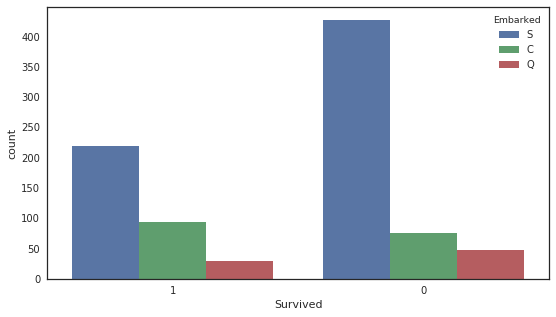

In [39]:
# Let's plot it
sns.countplot(x='Survived', hue="Embarked", data=train_df, order=[1,0]);

In [40]:
# Create categorical dummy variables for Embarked values
for dataset in combine:
    binary_encoded = pd.get_dummies(dataset.Embarked)
    newcols = binary_encoded.columns
    dataset[newcols] = binary_encoded

    
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,7.2500,S,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,71.2833,C,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,7.9250,S,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,53.1000,S,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,8.0500,S,0,0,1,0,0,1,6,0,0,1


In [41]:
# Drop Embarked
for dataset in combine:
    dataset.drop('Embarked', axis=1, inplace=True)

## Handle continuous values in the Fare column

In [42]:
# Fill the NA values in the Fares column with the median
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,2,7.8292,0,0,1,0,0,1,6,0,1,0
1,893,3,1,2,7.0000,0,0,0,1,0,0,6,0,0,1
2,894,2,0,3,9.6875,0,0,1,0,0,1,6,0,1,0
3,895,3,0,1,8.6625,0,0,1,0,0,1,3,0,0,1
4,896,3,1,1,12.2875,0,0,0,1,0,0,3,0,0,1


In [43]:
# q cut will find ranges equal to the quartile of the data
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [44]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    
    dataset.loc[(dataset['Fare'] > 7.91) & \
                    (dataset['Fare'] <= 14.454), 'Fare'] = 1
    
    dataset.loc[(dataset['Fare'] > 14.454) & \
                    (dataset['Fare'] <= 31), 'Fare']   = 2
    
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]

## Finished

In [45]:
train_df.head(7)
# All features are approximately on the same scale
# no need for feature engineering / normalization

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,0,3,0,1,0,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,3,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,1,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,3,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,1,0,0,1,0,0,1,6,0,0,1
5,0,3,0,1,1,0,0,1,0,0,1,3,0,1,0
6,0,1,0,3,3,0,0,1,0,0,1,3,0,0,1


In [46]:
test_df.head(7)

,PassengerId,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,C,Q,S
0,892,3,0,2,0,0,0,1,0,0,1,6,0,1,0
1,893,3,1,2,0,0,0,0,1,0,0,6,0,0,1
2,894,2,0,3,1,0,0,1,0,0,1,6,0,1,0
3,895,3,0,1,1,0,0,1,0,0,1,3,0,0,1
4,896,3,1,1,1,0,0,0,1,0,0,3,0,0,1
5,897,3,0,0,1,0,0,1,0,0,1,0,0,0,1
6,898,3,1,1,0,0,1,0,0,0,1,3,0,1,0


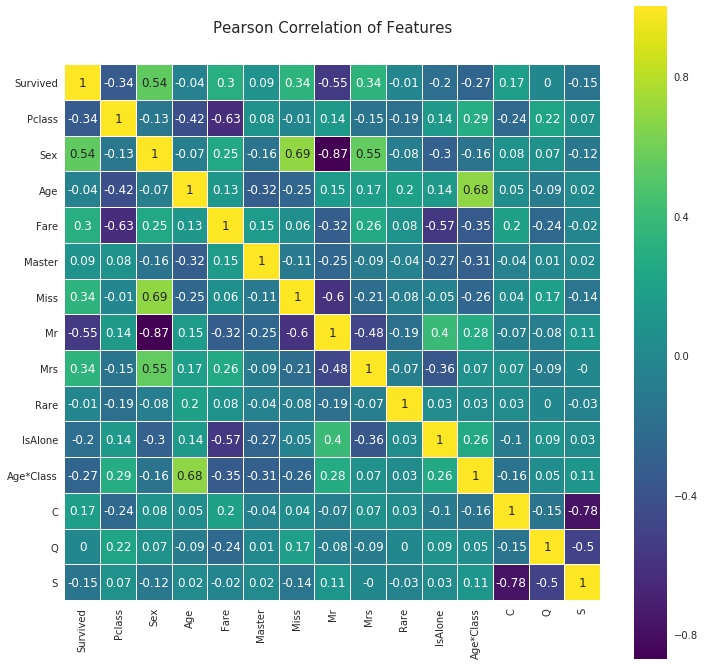

In [47]:
# Check correlation between features 
# (uncorrelated features are generally more powerful predictors)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

# Next Up: Machine Learning!
Now we will Model, Predict, and Choose algorithm for conducting the classification
Try using different classifiers to model and predict. Choose the best model from:
* Logistic Regression
* KNN 
* SVM
* Naive Bayes
* Decision Tree
* Random Forest
* Perceptron
* XGBoost

## Setup Train and Validation Set

In [48]:
X = train_df.drop("Survived", axis=1) # Training & Validation data
Y = train_df["Survived"] # Response / Target Variable

# Since we don't have labels for the test data
# this won't be used. It's only for Kaggle Submissions
X_submission  = test_df.drop("PassengerId", axis=1).copy() 

print(X.shape, Y.shape)



(891, 14) (891,)


In [49]:
# Split training and test set so that we test on 20% of the data
# Note that our algorithms will never have seen the validation 
# data during training. This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(712, 14) (712,)
(179, 14) (179,)


## Scikit-Learn general ML workflow
1. Instantiate model object
2. Fit model to training data
3. Let the model predict output for unseen data
4. Compare predicitons with actual output to form accuracy measure

# Logistic Regression

In [50]:
logreg = LogisticRegression() # instantiate
logreg.fit(X_train, Y_train) # fit
Y_pred = logreg.predict(X_val) # predict
acc_log = round(logreg.score(X_val, Y_val) * 100, 2) # evaluate
acc_log


78.209999999999994

In [51]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_val)
acc_svc = round(svc.score(X_val, Y_val) * 100, 2)
acc_svc

84.359999999999999

In [52]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_val)
acc_knn = round(knn.score(X_val, Y_val) * 100, 2)
acc_knn

79.329999999999998

In [53]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_val)
acc_perceptron = round(perceptron.score(X_val, Y_val) * 100, 2)
acc_perceptron

77.650000000000006

In [54]:
# XGBoost

gradboost = xgb.XGBClassifier(n_estimators=1000)
gradboost.fit(X_train, Y_train)
Y_pred = gradboost.predict(X_val)
acc_perceptron = round(gradboost.score(X_val, Y_val) * 100, 2)
acc_perceptron

83.799999999999997

In [55]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_val)
acc_random_forest = round(random_forest.score(X_val, Y_val) * 100, 2)
acc_random_forest

82.680000000000007

Training accuracy Random Forest: 0.869382022472


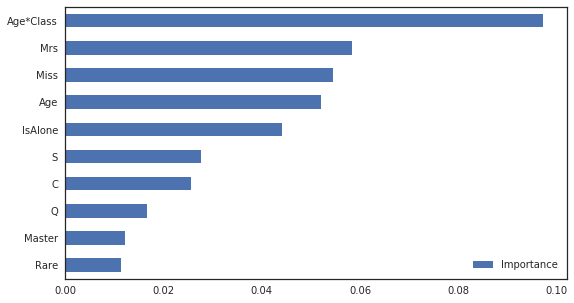

In [56]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

In [ ]:
# How to create a Kaggle submission:
Y_submission = random_forest.predict(X_submission)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_submission
    })
submission.to_csv('titanic.csv', index=False)

# Legacy code (not used anymore)

```python
# Map title string values to numbers so that we can make predictions

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) 
    # Handle missing values

train_df.head()
```

```python
# Drop the unnecessary Name column (we have the titles now)

train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape
```

```python
# Create categorical dummy variables for Embarked values
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()
```